# Практическая часть ДЗ 3

# Задача 1. Томография (20 баллов)

В этом задании мы попробуем построить томограмму некоторого объекта, пользуясь данными об интенсивности лучей, прошедших через него.


In [117]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sparse
import scipy.sparse.linalg as spla


### Генерация данных

Загрузим сечение анализируемой структуры из файла. Можно представлять, что мы анализируем, например, альвеолы в лёгких. Или колонию клеток.

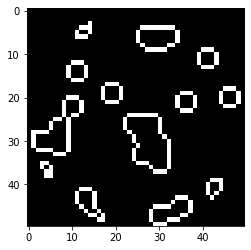

In [118]:
data = np.load("data/tomography.npy")
plt.imshow(data, cmap="gray")
n = data.shape[0]
assert (n, n) == data.shape

Томограф работает так: лучи испускаются из источника, проходят через анализируемую структуру и попадают на детектор (посмотрите картинки по [ссылке](https://plus.maths.org/content/saving-lives-mathematics-tomography)). По интенсивности луча, пришедшего в детектор можно понять, сколько энергии было поглощено по пути. В этой задаче мы будем считать, что количество поглощённой энергии пропорционально количеству пересечённых белых пикселей.

Мы хотим научиться считать величину $p_{\alpha, y}$ &mdash; количество белых пикселей, пересечённых прямой с заданным углом наклона $\alpha$ и проходящих через точку с координатой $(0, y)$ (оси $x,y$ проходят через центр картинки).


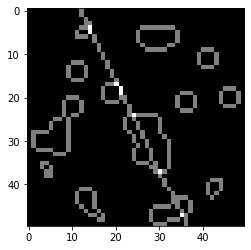

In [119]:
line = np.zeros((n,n))
I = np.arange(n)
J = (I * np.sin(np.pi/6) + n//4).astype(int)
mask = (J >= 0) & (J < n)
line[I[mask], J[mask]] = 1
_ = plt.imshow(data + line, cmap="gray")

Но делать это вычисление мы хотим одновременно для набора углов $\{\alpha_1, \dots, \alpha_s\}$ и набора координат $\{y_1, \dots, y_t\}$. Поэтому мы сформируем матрицу $P$ размера $st \times n^2$, которая при умножении на вытянутую в столбец картинку `data` даст столбец, состоящий из величин $p_{\alpha_i, y_j}$.

Систему координат мы разместим в центре картинки, ось X направим вверх, ось Y вправо. Таким, образом, точка $(x,y)$ примерно соответствует пикселю `data[y + n//2, -x + n//2]`. Реализуем функцию `build_projection_operator`, возвращающую матрицу $P$.

In [120]:
def build_projection_operator(n, alphas, ys):
    P = np.zeros((len(alphas) * len(ys), n**2))
    index = 0
    for alpha in alphas:
        tan = np.tan(alpha)
        cotan = np.tan(np.pi/2 - alpha)
        for y0 in ys:
            if np.abs(tan) <= 1:
                X = np.arange(-n//2, n//2)
                Y = y0 + X * tan
                mask = (Y > -n/2.) & (Y < n/2.)
            else:
                Y = np.arange(-n//2, n//2)
                X = (Y - y0) * cotan
                mask = (X > -n/2.) & (X < n/2.)
            X = np.clip(X + n//2, 0, n - 1)
            Y = np.clip(n//2 - Y, 0, n - 1)
            I = Y[mask].astype(np.int64)
            J = X[mask].astype(np.int64)
            P[index, I + J * n] = 1
            index += 1
    return P

In [121]:
n_alphas = 20
n_ys = 64
alphas = np.linspace(0, np.pi, num=n_alphas, endpoint=False)
ys = np.linspace(-n/2., n/2., num=n_ys)
P = build_projection_operator(n, alphas, ys)
P.shape

(1280, 2500)

Выведем несколько строк матрицы `P` в виде картинок и убедимся, что они соответствуют лучам томографа.

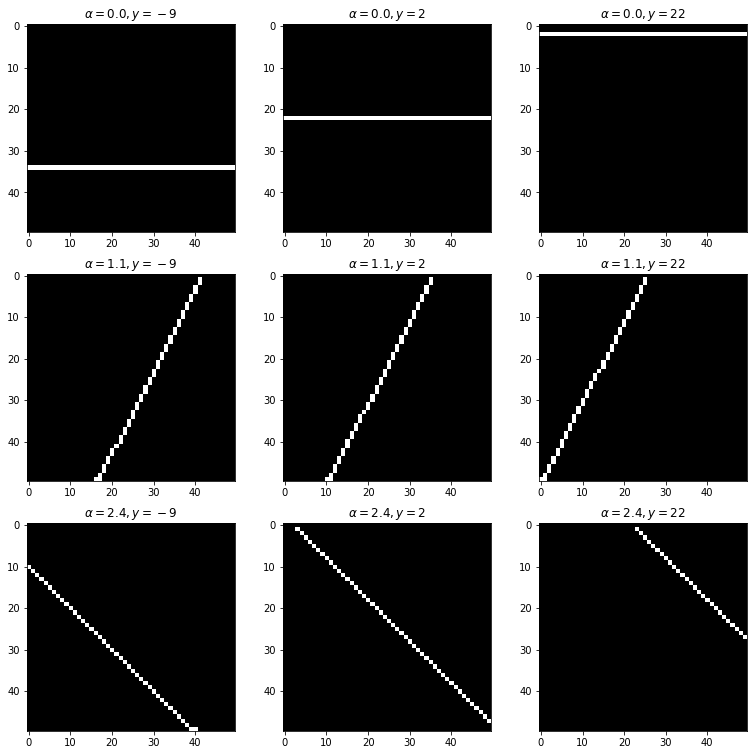

In [122]:
fig, axs = plt.subplots(3, 3, figsize=(13,13))
for i, i_alpha in enumerate([0, 7, 15]):
    for j, i_y in enumerate([20, 35, 60]):
        axs[i,j].imshow(np.reshape(P[i_y +  i_alpha * n_ys, :], (n, n)).T, cmap="gray")
        axs[i,j].set_title("$\\alpha = {:.2}, y = {}$".format(alphas[i_alpha], int(ys[i_y])))

  1. **(2 балла)** Сформируйте проекцию, используя матрицу $P$ и исходную картинку `data`.

In [123]:
data_vect = data.reshape(n * n, order="f")
print(P.shape, data_vect.shape)
projection = P @ data_vect
print(projection)

(1280, 2500) (2500,)
[0. 3. 6. ... 0. 0. 0.]


Порешейпим проекцию так, чтобы строки соответствовали углам $\alpha_i$, а столбцы &mdash; сдвигам $y_j$.

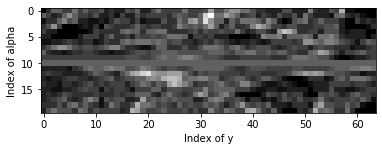

In [124]:
plt.imshow(np.reshape(projection, (n_ys, n_alphas), order="f").T, cmap="gray")
plt.xlabel("Index of y")
_ = plt.ylabel("Index of alpha")

   2. **(По желанию)** Попробуйте объяснить одноцветную линию, соответствующую углу $\alpha = \frac{\pi}{2}$ (горизонтальная линия в середине последнего графика).

### Получение томограммы по проекции

Для восстановления исходной структуры по проекциям, необходимо решить уравнение $Px = b$, где столбец $b$ содержит проекции.
Так как матрица $P$ имеет больше столбцов, чем строк, то система является **недоопределённой**, то есть одни и те же проекции могло дать бесконечно большое количество исходных структур $x$. Если же мы наложим дополнительное требование, чтобы 2-норма вектора $x$ была минимальна, то полученная задача
$$
\|x\|_2 \to \min_{Px=b}
$$
имеет известное решение $x = P^+b$. Поэтому в данном разделе вам необходимо найти псевдообратную матрицу к $P$. Так как в вычислениях с плавающей точкой задача нахождения псевдообратной является некорректно поставленной (из-за того, что сравнение сингулярных чисел с нулём не имеет смысла), то на практике обычно вычисляют $\delta$-псевдообратные матрицы. При их вычислении отбрасываются все сингулярные числа, меньшие $\delta$. Полученная матрица обозначается $P^+_\delta$.

Если исходная матрица имеет много малых сингулярных чисел, то имеет смысл не вычислять $P^+_\delta$ в явном виде, а использовать для вычислений компактное SVD этой матрицы, то есть разложение, в котором матрицы $U$ и $V$ имеют по $\mathrm{rank}(P^+_\delta)$ столбцов. Мы так и поступим.

   3. **(5 баллов)** Напишите функцию `pseudoinverse`, вычисляющую для заданной матрицы $P$ сингулярное разложение её $\delta$-псевдообратной.
Необходимо вернуть компактное SVD матрицы $P^+_\delta$.
Для вычисления используйте сингулярное разложение матрицы $P$. Использовать функцию `np.linalg.pinv` запрещено.

In [125]:
print(P.shape) # rk(P) <= 1280

(1280, 2500)


In [126]:
def pseudoinverse_svd(P, threshold=1e-15):
    
    U, S, Vt = np.linalg.svd(P, full_matrices=False)
    S_p = np.array([ 1 / e for e in S if e > threshold])
    r = len(S_p)
    # print("rank is", r)
    return Vt.T[:, :r], S_p, U.T[:r, :]

Проверим, что псевдообратная совпадает с обратной для квадратной невырожденной матрицы $A$ (случайная матрица с вероятностью, очень близкой к единице, является невырожденной).

In [127]:
A = np.random.random((3, 3))
U, S, VT = pseudoinverse_svd(A)
pinv = np.multiply(U, S) @ VT
assert np.linalg.norm(pinv @ A - np.eye(3)) < 1e-12

   4. **(3 балла)** С помощью сингулярного разложения $\delta$-псевдообратной к $P$ и вектора `tomogram` восстановите изображение. Для получения полного балла сложность вычисления восстановленного изображения (без учета SVD) должна быть $O(n^2r + r st)$, где $r = \mathrm{rank}(P^+_\delta)$. Иными словами, нельзя формировать полную матрицу $P^+_\delta$. **Обратите внимание:** дефолтное значение параметра `threshold` не очень подходит для данной задачи, вместо этого рекомендуем использовать `threshold=1`.

In [128]:
U, S, Vt = pseudoinverse_svd(P, threshold=1)
# projection = P @ data_vect
# Хотим: data

print("Shapes:")
# print("Pinv:", U.shape[0], Vt.shape[1])
print("Projection:", projection.shape)
print("U, S, Vt:", U.shape, np.diag(S).shape, Vt.shape)
print("st = ", P.shape[0], ", n^2 = ", P.shape[1], sep='')

# n^2 r^2: 2500 * r x r * r - U @ Sigma
# r  st: r * 1280 x 1280 * 1 - V @ Pr
# n^2 r:s 2500 * r x r * 1 - (U @ Sigma) @ (V @ Pr)
# O(n^2 r^2 + r st)

reconstructed_pinv = (U @ np.diag(S)) @ (Vt @ projection)

Shapes:
Projection: (1280,)
U, S, Vt: (2500, 1123) (1123, 1123) (1123, 1280)
st = 1280, n^2 = 2500


Проверьте своё решение: убедитесь, что $\frac{\|P x_{reconstructed} - b\|_2}{\|b\|_2}$ не очень велико, а также выведите в виде изображения вектор `reconstructed_pinv`. На картинке должны достаточно чётко виднеться контуры объектов, особенно близких к центру (**опционально**: можете ли вы неформально объяснить тот эффект, что лучше восстанавливаются объекты, более близкие к центру?)

In [129]:
assert np.linalg.norm(P @ reconstructed_pinv - projection) / np.linalg.norm(projection) < 1e-2

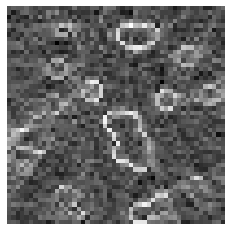

In [130]:
plt.imshow(reconstructed_pinv.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

### Ridge regression

Теперь попробуем подойти к восстановлению изображения с другой стороны: будем решать при фиксированном $\mu > 0$ так называемую $\ell_2$-регуляризованную задачу наименьших квадратов (в англоязычной литературе ridge regression):
$$
\|Px - b\|_2^2 + \mu \|x\|_2^2 \to \min
$$
($b$ здесь означает вектор `projection`).
Смысл состоит в том, что мы хотим, чтобы одновременно и $x$ давала проекцию, похожую на $b$, и при этом сам вектор $x$ не был слишком велик по норме.

Для решения этой задачи запишем условие равенства нулю градиента этой функции:
$$
2(Px-b)^\top P + 2\mu x^\top = 0 \Leftrightarrow (P^\top P + \mu I)x = P^\top b.
$$

   5. **(5 баллов)** Используя компактное SVD $P$, напишите тело функции `ridge_regression`, решающую указанную задачу минимизации для заданных $P$, $b$ и $\mu$. Для получения полного балла не формируйте нигде матриц размером $n^2 \times n^2$.

$(P^\top P + \mu I)x = P^\top b$.\
Распишем P по его SVD: $P = USV^T$\
Тогда $P^T = VS^TU^T$\
Если рассматриваем SVD с параметром *full_matrices=False*, то следует ожидать, что матрица $V^T$ не будет квадратной.\
Тогда придется искать ее псевдообратную матрицу.\
$P^TP = VS^TU^T USV^T = V S^2 V^T$\
Тогда $(V S^2 V^T + \mu I)x = VS^TU^T b$\
Домножим на $V^T$ слева с обоих сторон.\
$(V^T V S^2 V^T + \mu V^T)x = V^T VS^TU^T b \Longrightarrow (S^2 V^T + \mu V^T)x = S^TU^T b$\
Кстати, $V^T$ можно вынести справа:\
$(S^2 + \mu I)V^Tx = S^TU^T b$, $S^T = S$ в силу ее губкобобости (квадратности).\
Тогда $x = ((S^2 + \mu I)V^T)^{-1} S U^T b = (V^T)^{+} (S^2 + \mu I)^{-1} S U^T b$\
Если берем полное SVD, то обратная матрица везде определена.

In [131]:
def ridge_regression(P, b, mu):
    
    U, S, Vt = np.linalg.svd(P, full_matrices=False)
    S2 = S ** 2
    r = len(S)
    M = np.linalg.inv(np.diag(S2) + mu * np.eye(r, r))
    Up, Sp, Vtp = pseudoinverse_svd(Vt)
    Vt_pinv = Up @ np.diag(Sp) @ Vtp
    print(Vt_pinv.shape, M.shape, np.diag(S).T.shape, U.T.shape, b.shape)
    # По полученным размерам видно, что матрица размера 2500 x 2500 создана не будет
    # при любом порядке умножения
    
    x = Vt_pinv @ M @ np.diag(S) @ U.T @ b
    return x

In [132]:
reconstructed_ridge = ridge_regression(P, projection, 1)

(2500, 1280) (1280, 1280) (1280, 1280) (1280, 1280) (1280,)


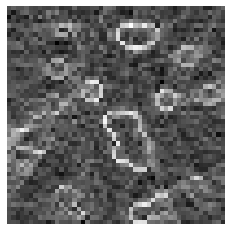

In [133]:
plt.imshow(reconstructed_ridge.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

Обратите внимание, насколько похож результат решения задачи ridge regression на решение с помощью псевдообратной. Это неслучайно: можно показать, что эти два подхода тесно взаимосвязаны, а в пределе при $\mu, \delta \to 0$ дают одинаковые векторы.

### Lasso

Если в ridge regression вместо квадрата второй нормы $x$ использовать первую норму (то есть ставить $\ell_1$-регуляризованную задачу наименьших квадратов), то получится такая задача минимизации:
$$
\|Px-b\|_2^2 + \mu \|x\|_1 \to \min.
$$

Такая задача оказывается более подходящей в нашем случае, так как её решение часто оказывается разреженным (получить некоторую интуицию о том, почему так происходит, можно, например, [тут](https://medium.com/analytics-vidhya/intuition-behind-l1-l2-regularisation-2ac1e6a1bd81); более развёрнутое описание метода есть в [википедии](https://en.wikipedia.org/wiki/Lasso_(statistics))).

   6. **(4 баллов)** Заполните пропуски в теле функции `solve_lasso`. Воспользуйтесь документацией к классу [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).


In [134]:
from sklearn.linear_model import Lasso

def solve_lasso(P, b):
    lasso = Lasso(alpha=0.001)
    lasso.fit(P, b)
    # rec_L1 = lasso.coef_.reshape(n, n)
    return lasso.coef_

In [135]:
reconstructed_lasso = solve_lasso(P, projection)

(2500,)


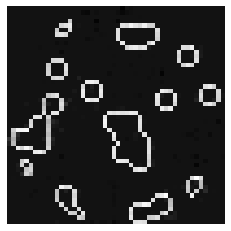

In [136]:
print(reconstructed_lasso.shape)
plt.imshow(reconstructed_lasso.reshape(n, n, order='f'), cmap='gray'); _ = plt.axis('off')

Сравним все три полученных решения с исходной структурой.

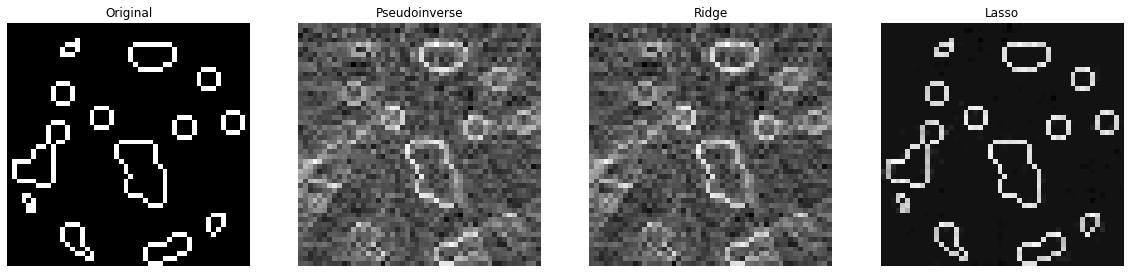

In [137]:
fig, axs = plt.subplots(1,4, figsize=(20,30))
for i, (im, name) in enumerate([
    (data, "Original"),
    (reconstructed_pinv.reshape(n, n, order='f'), "Pseudoinverse"),
    (reconstructed_ridge.reshape(n, n, order='f'), "Ridge"),
    (reconstructed_lasso.reshape(n, n, order='f'), "Lasso"),
]):
    axs[i].imshow(im, cmap="gray")
    axs[i].set_title(name)
    axs[i].axis('off')

# Задача 2. Быстрое вычисление дискретной свертки (35 баллов)

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

**Обратите внимание:** <font color='red'>во всех пунктах данной задачи запрещается использовать циклы.</font>

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

(256, 256)


C:\Users\Oleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


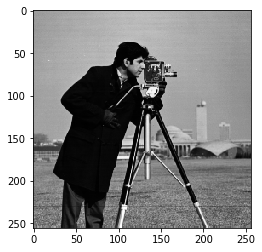

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(np.float)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

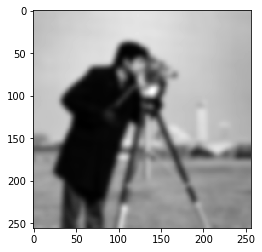

In [139]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. (5 баллов) Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть $$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).

 - **(5 баллов)** Покажите, что результат $B$ применения такой операции к матрице $A$ можно представить в виде
$$
    B = T_m A T_n^T,
$$
где 
$$
(T_n)_{i,j} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(i-j)^2}{2\sigma^2}\right)
$$

### Ансвер:
Пусть $A \in \mathbb{C}^{m \times n}$. Будем рассматривать элемент $B_{ij}$. Для начала умножим $T_m A \in \mathbb{C}^{m \times n}$:\
$$
(T_m A)_{id} = \sum\limits_{k = 0}^{m} (T_m)_{ik} \times A_{kd}
$$
$$
B_{ij} = (T_m A T_n^T)_{ij} = \sum\limits_{d = 0}^{n} (T_m A)_{id} \times (T_n^T)_{dj} = \sum\limits_{d = 0}^{n} (T_m A)_{id} \times (T_n)_{jd} = \sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} (T_m)_{ik} \times A_{kd} \times (T_n)_{jd}
$$
$$
B_{ij} = \sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} 
(T_m)_{ik} 
(T_n)_{jd} 
\times A_{kd} = \sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} 
\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(i-k)^2}{2\sigma^2}\right) 
\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(j-d)^2}{2\sigma^2}\right)
\times A_{kd} =
$$
$$
= \sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} \frac{1}{2\pi\sigma^2}
\exp\left(-\frac{(i-k)^2}{2\sigma^2} -\frac{(j-d)^2}{2\sigma^2}\right)
\times A_{kd} = 
\sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} \frac{1}{2\pi\sigma^2}
\exp\left(-\frac{(i-k)^2}{2\sigma^2} -\frac{(j-d)^2}{2\sigma^2}\right)
\times A_{kd} =
$$
$$
= \sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} \frac{1}{2\pi\sigma^2}
\exp\left(-\frac{(i-k)^2 + (j-d)^2}{2\sigma^2}\right)
\times A_{kd}
$$
Заметим следующее:
$$
\frac{1}{2\pi\sigma^2}
\exp\left(-\frac{(i-k)^2 + (j-d)^2}{2\sigma^2}\right)
= G((i-k), (j-d))
$$
Тогда все становится совсем просто:
$$
B_{ij} = \sum\limits_{d = 0}^{n} \sum\limits_{k = 0}^{m} G((i-k), (j-d)) \times A_{kd}
$$
Индекс $(i, j)$ - это координаты какого-то пикселя. $-k,\ -d$, учитывая суммы, можно считать как смещения пикселя. Тогда можно сказать, что $G((i-k), (j-d)) = G((\Delta i, \Delta j)$. Отсюда
$$
B = T_m A T_n^T = G A,
$$
Что и требовалось доказать.

### b. (19 баллов) Имплементация одномерных сверток

- **(8 баллов)** Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своей первой строки. При вычислениях нигде не должна возникнуть полная матрица $T_m$.

В лекции мы использовали первый столбец $T_m$ для вычисления. Но легко заметить, что $(T_m)_{ij} = (T_m)_{ji}$, поэтому нам хватит и первой строки.

In [140]:
def convolve_1D(A, T_row):

    m, n = A.shape[0], A.shape[1]
    c = np.concatenate((T_row, (T_row[1:])[::-1]),axis=0) # m + m - 1
    Z = np.zeros((m - 1, n))
    A_z = np.concatenate((A, Z),axis=0)
    
    c = np.fft.fft(c).T
    
    def foo(column):
        fft_col = np.fft.fft(column)
        return np.fft.ifft(c * fft_col)[:m]
    # Нужно применить метод к каждому столбцу и сложить все в итоговую матрицу
    # https://numpy.org/doc/stable/reference/generated/numpy.apply_along_axis.html
    out = np.apply_along_axis(foo, 0, A_z)
    
    return out

Напишем также функцию `form_T_row`, которая будет создавать первую строку матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

In [141]:
from scipy.linalg import toeplitz

def form_T_row(m, sigma):
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp((-1. / sigma**2) * np.arange(m)**2)
    
def form_T(m, sigma):
    return toeplitz(form_T_row(m, sigma))

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [142]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_row = form_T_row(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_row))

2.2474722514611155e-14

- **(2 балла)** Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.

Разберем по пунктикам.\
$A \in \mathbb{C}^{m \times n}$, тогда матрица A, дополненная снизу нулевой матрицей $Z$ размера $(m - 1) \times n$, будет называться $A_z$ и иметь размер $(2m - 1) \times n$. Вместо полной матрицы $T_m$ мы берем лишь столбец размером $2m - 1$.\
Не будем брать в расчем время построения необходимых объектов для вычисления. `fft(v)` для вектора размера $2m - 1$ займет $O(mlogm)$ времени. Адамарово произведение - линейное - $O(m)$. Значит, заранее посчитав `fft(c)`, функция `foo(v)` занимает $O(mlogm + m + mlogm)$ времени, так как `ifft()` тоже выполняется за $O(mlogm)$. Таким образом, на $foo()$ приходится $O(mlogm)$ времени, но `foo(v)` выполняется для каждого столбца $v$ матрицы $A$, посему по итогу получим $O(mlogm + nmlogm) = O(nmlogm)$ времени, учитывая единичное построение `fft(с)` для столбца тёплицевой матрицы. Таким образом, `convolve_1D` сработает за $O(nmlogm) + \tau$ времени, где $\tau$ - какое-то время на построение объектов и обрезку [:m]. Можно сказать, что $\tau \sim O(mn)$, и тогда получим просто $O(nmlogm)$.

- **(3 балла)** Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильную строку `T_row` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [143]:
def gauss_convolve_1D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            B: m x n matrix, B = G_m @ A
    """
    m, n = A.shape[0], A.shape[1]
    T_row = 1. / (2 * np.pi * sigma ** 2) * np.exp((-1. / sigma**2) * np.arange(m)**2)
    
    return convolve_1D(A, T_row)

- **(2 балла)** Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

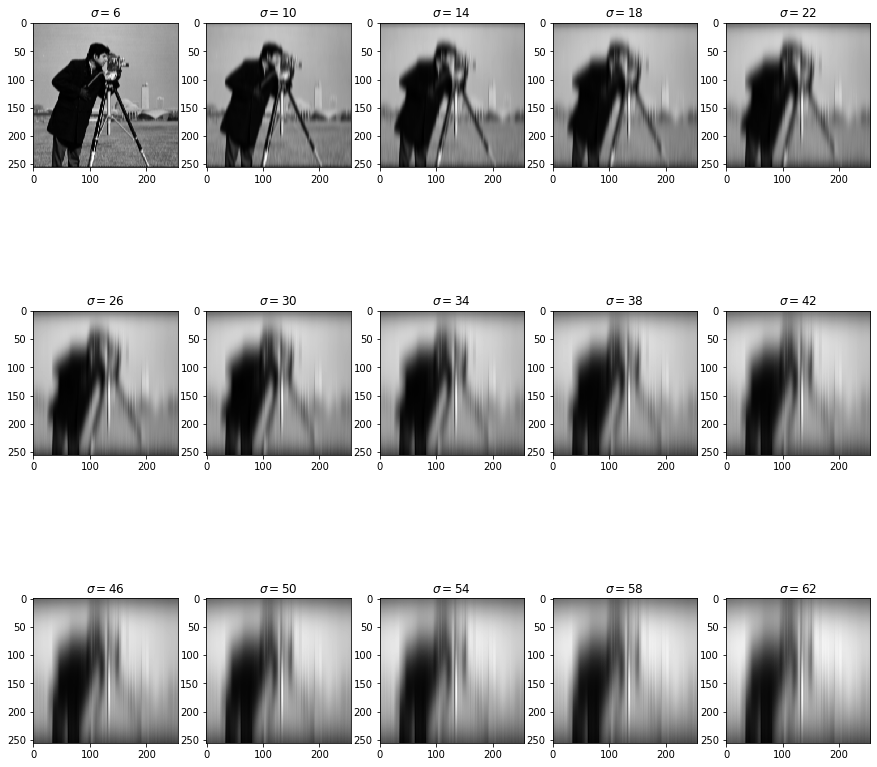

In [228]:
fig, axs = plt.subplots(3, 5, figsize=(15,15))
sigma = 2
for i in range(3):
    for j in range(5):
        im = gauss_convolve_1D(A, sigma).real
        sigma += 4
        axs[i,j].imshow(im, cmap="gray")
        axs[i,j].set_title("$\\sigma = {}$".format(sigma))

Чем больше значение стандартное отклонение гауссова распределения, тем сильнее размытие. К слову, очень заметно, что выполняется именно 1D свертка - эффект такой, как будто бы мы смотрим в окно, по которому прошлись мокрой тряпкой сверху вниз, а черные полосы только по вертикльным краям.

### c. (7 баллов) Вычисление двумерной свертки

- **(5 баллов)** Теперь вы уже без труда сможете написать функцию двумерной свёртки: $B = G_m A G_n^T$ ...

In [145]:
def gauss_convolve_2D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            С: m x n matrix, B = G_m @ A @ G_n.T
            
    """
    #  A @ G_n.T = (G_n @ A.T).T
    GA = gauss_convolve_1D(A.T, sigma)
    GA = GA.T
    
    return gauss_convolve_1D(GA, sigma)

...и визуально проверить, правильно ли она работает.

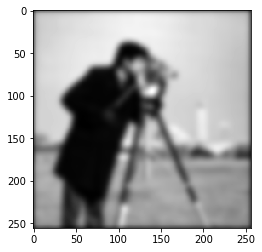

In [146]:
A_conv = gauss_convolve_2D(A, 5)
_ = plt.imshow(A_conv.real, cmap='gray')

- **(1 балл)** Объясните эффект тёмных полос около края картинки.

**Было сказано:**\
"Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость".\
Здесь же мы видим, что пиксели у краев значительно затемнились. Как человеку, которому доводилось редачить фотки в фотошопе, мне знаком такой эффект. В [документации](https://helpx.adobe.com/ru/photoshop/using/filter-effects-reference.html) сказано, что гауссовские шумы добавляются именно с захватом пикселей вне зоны выделения.\
Если этого не делать, то в этом случае граничные пиксели не имеют за собой вообще ничего, тогда эти "соседние" пиксели входят со значением, близким к нулю - черный цвет и его оттенки. Поэтому такой эффект и получается. 

### d. (9 баллов) Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа.

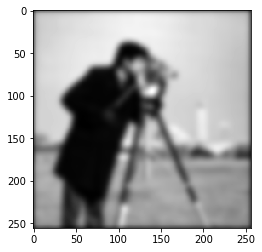

In [147]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma).real
_ = plt.imshow(A_conv, cmap='gray')

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [148]:
m, n = A_conv.shape
T_m, T_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(T_m, A_conv)
A_rec = np.linalg.solve(T_n, B.T).T

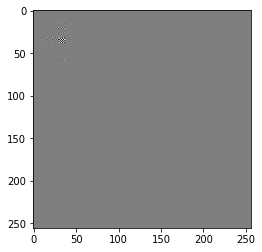

In [149]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $T_m$.

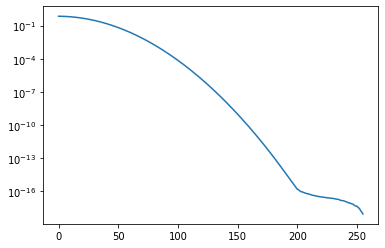

In [150]:
s = np.linalg.svd(T_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы (хотя пока мы не умеем это формализовывать), потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить "приближённый" $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся (легко проверить) тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

- **(9 баллов)** Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирут изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```. **Замечание:** В данном случае ```np.linalg.pinv``` выдаст всю псевдообратную матрицу, что подойдет в качестве решения. Но можно сделать немного эффективнее, если явно умножать на компоненты компактного SVD. 

In [151]:
def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    
    m, n = A_conv.shape[0], A_conv.shape[1] 
    T_m = form_T(m, sigma)
    T_nt = form_T(n, sigma).T
    
    TM = pseudoinverse_svd(T_m, threshold=tol)
    TNt = pseudoinverse_svd(T_nt, threshold=tol)
    
    one = TM[0] @ np.diag(TM[1])
    two =  np.diag(TNt[1]) @ TNt[2]
    M = TM[2] @ A_conv @ TNt[0]
    
    return one @ M @ two

Посмотрим на получившийся результат.

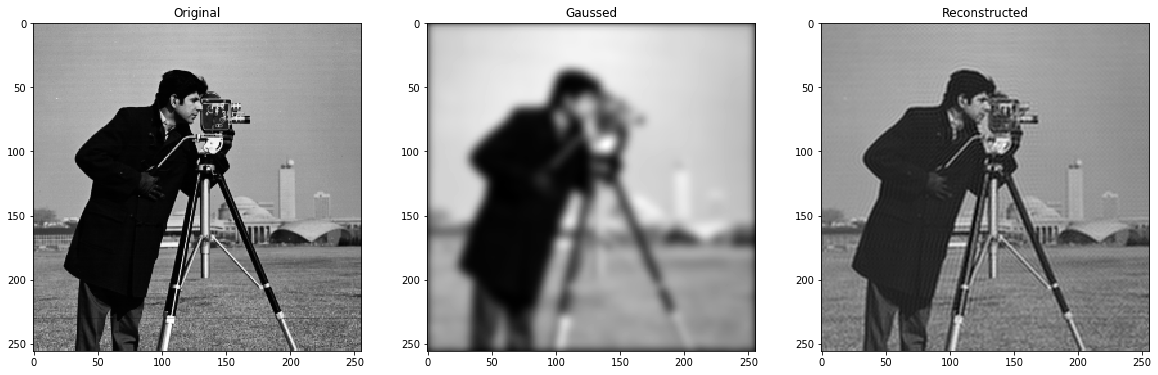

In [152]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(A_conv, cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(A_rec, cmap='gray')
_ = axs[2].set_title("Reconstructed")